<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/Word2VecCBOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab import  drive
drive.mount('/content/drive')

device_name = tf.test.gpu_device_name()
print(device_name)
df_train = pd.read_csv('/content/drive/My Drive/InfluenceAnalysis/Data/Train/clean_all_train.csv')

def generate_dictionary_data(text):
  word_to_index= dict()
  index_to_word = dict()
  corpus = []
  count = 0
  vocab_size = 0    
  for row in text:
    for word in row.split():
      corpus.append(word)
      if word_to_index.get(word) == None:
        word_to_index.update ( {word : count})
        index_to_word.update ( {count : word })
        count  += 1
      vocab_size = len(word_to_index)
      length_of_corpus = len(corpus)
  return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

def get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index):
  trgt_word_vector = np.zeros(vocab_size)  
  index_of_word_dictionary = word_to_index.get(target_word) 
  trgt_word_vector[index_of_word_dictionary] = 1  
  ctxt_word_vector = np.zeros(vocab_size)
  for word in context_words:
    index_of_word_dictionary = word_to_index.get(word) 
    ctxt_word_vector[index_of_word_dictionary] = 1    
  return trgt_word_vector,ctxt_word_vector

def generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,batch_size):
  while True:
    for k in range(int(length_of_corpus/batch_size)):
      training_data_target =  []
      training_data_context =  []
      for i,word in enumerate(corpus[batch_size*k:min(len(corpus),(batch_size*(k+1)))]):
        cor = corpus[batch_size*k:min(len(corpus),(batch_size*(k+1)))]
        length_of_cor = len(cor)
        index_target_word = i
        target_word = word
        context_words = []
        #when target word is the first word
        if i == 0:  
          # trgt_word_index:(0), ctxt_word_index:(1,2)
          context_words = [cor[x] for x in range(i + 1 , window_size + 1)] 
        #when target word is the last word
        elif i == length_of_cor-1:
          # trgt_word_index:(9), ctxt_word_index:(8,7), length_of_corpus = 10
          context_words = [cor[x] for x in range(length_of_cor - 2 ,length_of_cor -2 - window_size  , -1 )]
        #When target word is the middle word
        else:
          #Before the middle target word
          before_target_word_index = index_target_word - 1
          for x in range(before_target_word_index, before_target_word_index - window_size , -1):
            if x >=0:
              context_words.extend([cor[x]])
          #After the middle target word
          after_target_word_index = index_target_word + 1
          for x in range(after_target_word_index, after_target_word_index + window_size):
            if x < length_of_cor:
              context_words.extend([cor[x]])
        trgt_word_vector,ctxt_word_vector = get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index)
        training_data_target.append(trgt_word_vector)
        training_data_context.append(ctxt_word_vector)
      yield (np.array(training_data_context),np.array(training_data_target))
      del training_data_target
      del training_data_context


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/device:GPU:0


In [ ]:
#
epochs_num = 20
window_size = 3
embedding_dimensions = 96
batch_size = 128
#
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictionary_data(df_train['Tweets'])
print(vocab_size)
print(len(corpus))

10220
58800


Epoch 1/20
459/459 [==============================] - 9s 19ms/step - loss: 7.8469 - accuracy: 0.0286
Epoch 2/20
459/459 [==============================] - 9s 19ms/step - loss: 7.1999 - accuracy: 0.0411
Epoch 3/20
459/459 [==============================] - 9s 19ms/step - loss: 6.9301 - accuracy: 0.0718
Epoch 4/20
459/459 [==============================] - 9s 19ms/step - loss: 6.5928 - accuracy: 0.0994
Epoch 5/20
459/459 [==============================] - 9s 19ms/step - loss: 6.1698 - accuracy: 0.1248
Epoch 6/20
459/459 [==============================] - 9s 19ms/step - loss: 5.6734 - accuracy: 0.1581
Epoch 7/20
459/459 [==============================] - 9s 19ms/step - loss: 5.1347 - accuracy: 0.1993
Epoch 8/20
459/459 [==============================] - 9s 19ms/step - loss: 4.5935 - accuracy: 0.2463
Epoch 9/20
459/459 [==============================] - 9s 19ms/step - loss: 4.0746 - accuracy: 0.3010
Epoch 10/20
459/459 [==============================] - 9s 19ms/step - loss: 3.5920 - accura

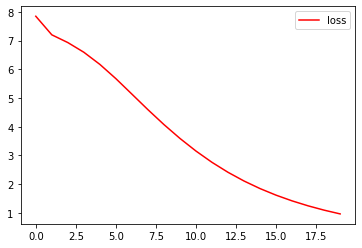

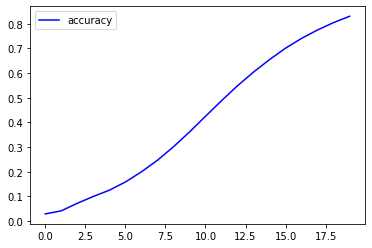

In [ ]:
model = keras.Sequential([keras.layers.Dense(embedding_dimensions),
                          keras.layers.Dense(vocab_size,activation = 'softmax')])
model.compile(optimizer = "adam", loss = 'categorical_crossentropy',metrics=["accuracy"])
history = model.fit(x = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,batch_size),steps_per_epoch=int(length_of_corpus/batch_size),epochs = epochs_num)
hist = pd.DataFrame(history.history)
print(hist.head())
plt.figure()
plt.plot(hist['loss'],c='r')
plt.legend(['loss'])
plt.show()
plt.plot(hist['accuracy'],c='b')
plt.legend(['accuracy'])
plt.show()

In [ ]:
def make_dict(index_to_word,weight_matrix):
  dict = {}
  for index,i in enumerate(weight_matrix):
    dict[index_to_word[index]] = i
  return dict
dict = make_dict(index_to_word,model.get_weights()[2].T)
len(dict)

10220

In [ ]:
df = pd.DataFrame.from_dict(dict, orient="index")
df.to_csv("/content/drive/My Drive/InfluenceAnalysis/Word2VecCBOW/Dictionary.csv")

In [ ]:
def find_similar_20(word,dict):
  l = []
  word_val = {}
  if word in dict:
    for i in dict:
      word_val[i] = sum([x*y for x,y in zip(dict[i],dict[word])])
    word_val = {k: v for k, v in sorted(word_val.items(), key=lambda item: item[1],reverse=True)}
  c = 0
  for i in word_val:
    c += 1
    if c==21:
      break
    l.append(i)
  return l

In [ ]:
find_similar_20('happy',dict)

['happy',
 'good',
 'my',
 'Happy',
 'bday',
 'laugh',
 'fun',
 'â›…ï¸\x8fâ\x9d¤ï¸\x8fðŸ‡³ðŸ‡´ðŸ\x8f¢ðŸ’»ðŸ–¥ðŸ\x8f‹ðŸ\x8f»ðŸ’ªðŸ\x8f¼ðŸ“ºðŸ\x8d¿',
 'terror',
 'serious',
 'try',
 'sad',
 'healthy',
 'of',
 'leads',
 'since',
 'ing',
 'blessed',
 's',
 'excited']